In [ ]:
!pip install -U classiq

In [ ]:
import classiq
classiq.authenticate()

/usr/local/lib/python3.10/dist-packages/classiq/_internals/authentication/token_manager.py:99: UserWarning: Device is already registered.
Generating a new refresh token should only be done if the current refresh token is compromised.
To do so, set the overwrite parameter to true
  warnings.warn(


In [ ]:
!pip install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 8.8 MB/s eta 0:00:00


Our project topic is "**Exponential quantum speedup in simulating coupled classical oscillators**".

We need to implement the following three tasks for a toy problem:

1. Encoding of the problem.
2. The key algorithmic building blocks of the chosen paper (e.g.,
Hamiltonian simulation).
3. The readout and post-processing.

For the toy problem, we have decided to implement the smallest non-trivial system, with $N=2$, of two balls connected to springs with each other. The idea is to eliminate all the complications of the problem and just to focus on the key algorithmic elements.
We assumed M and K are diagonal matrices where all elements are 1, so A and B are diagonal as well. And we aim to observe the outcome of such system and the physical interpretation as well.

In [82]:
import json
import pathlib
import random
from typing import cast

import matplotlib.pyplot as plt
import numpy as np
import tqdm

from classiq import *
from classiq.execution import ExecutionPreferences

from qiskit.quantum_info import SparsePauliOp
import networkx as nx

# **Algorithm**
1. Get the masses of the balls and form the matrix $M$.
2. Get the spring constants and form the matrix $K$.
3. Calculate the matrix $A = (\sqrt{M})^{-1}K(\sqrt{M})^{-1}$.
4. Find $B$ such that $A = BB^{\dagger}$ using the Cholesky Decomposition.
5. Construct the Hamiltonian of the system $$H = \begin{pmatrix} 0 & B\\ B^{\dagger} & 0 \end{pmatrix}.$$
6. Decompose $H$ in Paulis using qiskit.
7. Simulate the time evolution of the Hamiltonian $H$ on the Classiq platform.
8. Use VQE to find the optimal energy.

### **Algorithm Inspiration**

For additional insights and examples, one may refer to the following reference:

**Exponential quantum speedup in simulating coupled classical oscillators** (https://doi.org/10.1103/PhysRevX.13.041041).


In [83]:
n = 1
# Number of masses in the coupled oscillators
N = 2**n # Classical coupled oscillator system of 2 masses/balls
masses = [1, 1]
def form_M(masses):
    return np.diag(masses)

M = form_M(masses) # Call the function to initialize M
print("Mass Matrix M:\n", M)

def form_K(N):
    """
    Forms a diagonal matrix K with all diagonal entries set to 1.

    Parameters:
    - N: Number of oscillators (masses).

    Returns:
    - K: The NxN diagonal matrix.
    """
    K = np.eye(N)  # Create an NxN identity matrix with ones on the diagonal
    return K

# Generate the K matrix as a diagonal matrix with ones
K = form_K(N)
print("Diagonal Matrix K:\n", K)


def compute_H(M, K):
  # Construct the matrix A from M and K
  A = np.dot(np.linalg.inv(np.sqrt(M)), np.dot(K, np.linalg.inv(np.sqrt(M))))
  print("Matrix A:\n", A)
  print("Is A symmetric?:", np.allclose(A, A.T))
   # Ensure A is positive semi-definite for Cholesky decomposition
  if not np.all(np.linalg.eigvals(A) >= 0):
        print("Matrix A is not positive semi-definite.")
        return None, None
  try:
    # Define B such that B B^† = A
    B = np.linalg.cholesky(A)  # Using Cholesky decomposition
    B_dagger = np.conjugate(B.T)
  except np.linalg.LinAlgError:
        print("Matrix A is not positive-definite.")
        return None, None
  print("Matrix B:\n", B)
  # Reconstruct A to check the result
  A_reconstructed = np.dot(B, B_dagger)
  print("Reconstructed A from B:\n", A_reconstructed)
  print("Is reconstructed A close to original A?:", np.allclose(A, A_reconstructed))
  # Construct the block Hamiltonian H
  H = np.block([[np.zeros((N, N)), B], [B_dagger, np.zeros((N, N))]])
  return H

H = compute_H(M, K)
print("Hamitonian Matrix H:\n",H)

eigenvalues = np.linalg.eigvals(H)
print("Eigenvalues of the Hamiltonian H:", eigenvalues)

Mass Matrix M:
 [[1 0]
 [0 1]]
Diagonal Matrix K:
 [[1. 0.]
 [0. 1.]]
Matrix A:
 [[1. 0.]
 [0. 1.]]
Is A symmetric?: True
Matrix B:
 [[1. 0.]
 [0. 1.]]
Reconstructed A from B:
 [[1. 0.]
 [0. 1.]]
Is reconstructed A close to original A?: True
Hamitonian Matrix H:
 [[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]
Eigenvalues of the Hamiltonian H: [ 1. -1.  1. -1.]


### Physical interpretation of the output:

- **Mass Matrix $M$**:
  - This matrix is the identity matrix for 2 masses, indicating that each mass has a unit value.

- **Diagonal Matrix $K$**:
  - This matrix is also the identity matrix, meaning each spring constant is 1 and there are no off-diagonal interactions in the generalized sense (each mass interacts only with itself in this representation, i.e., ignoring the interaction between a ball and a spring).

- **Matrix $A$**:
  - This result shows that $A$ is the same as $K$ in this particular case, which is expected given the form of $K$.

- **Matrix $B$**:

  - This result is the identity matrix, which is a valid Cholesky decomposition of $A$ (since $A$ is diagonal with positive entries).

- **Hamiltonian Matrix $H$**:
  
  - This matrix is structured to have $B$ in the off-diagonal blocks and $ B^\dagger$ in the remaining off-diagonal blocks. Here each oscialltors only interact with its negihbours. The off-diagonal elements insicate this coupling, in this case with uniform coupling strength.

  From the eigenvalues of $H$ we can see that the structure of
$H$ suggests coupling between different modes or states but does not account for the external forces or boundary conditions (e.g., wall interactions).


In [84]:
CHAR_TO_STUCT_DICT = {"I": Pauli.I, "X": Pauli.X, "Y": Pauli.Y, "Z": Pauli.Z}


def pauli_str_to_enums(pauli):
    return [CHAR_TO_STUCT_DICT[s] for s in pauli]


def pauli_list_to_hamiltonian(pauli_list):
    return [
        PauliTerm(
            pauli=pauli_str_to_enums(pauli), coefficient=cast(complex, coeff).real
        )
        for pauli, coeff in pauli_list
    ]


The above code block includes functions for handling Pauli matrices in quantum mechanics:

1. **CHAR_TO_STRUCT_DICT**:
   - A dictionary mapping Pauli matrix characters ("$I$", "$X$", "$Y$", "$Z$") to their corresponding Pauli matrix objects.

2. **Function `pauli_str_to_enums(pauli)`**:
   - Converts a list of Pauli matrix characters (e.g., ["$X$", "$Z$"]) into their corresponding Pauli matrix objects using `CHAR_TO_STRUCT_DICT`.

3. **Function `pauli_list_to_hamiltonian(pauli_list)`**:
   - Takes a list of tuples where each tuple contains a string of Pauli matrices and a coefficient.
   - Converts the Pauli matrix string to Pauli matrix objects and ensures the coefficient is a real number.
   - Returns a list of `PauliTerm` objects, each representing a term in a Hamiltonian with its Pauli matrices and coefficient.

### **Code Inspiration**

For additional insights and examples, one may refer to the following reference:

- [Classiq Documentation on Glued Trees Algorithm](https://docs.classiq.io/latest/explore/algorithms/glued_trees/glued_trees/?h=tr#quantum-algorithm)

In [85]:
def crop_pauli_list(pauli, size):
    if len(pauli) <= size:
        return pauli
    result = []
    idx = 0
    while len(result) < round(size * 0.6):
        for i in range(len(pauli[0][0]) - 1, -1, -1):
            for k in pauli:
                if k[0][i] == "IXYZ"[idx % 4] and k not in result:
                    result.append(k)
                    break
            idx += 1
    for i in pauli:
        if len(result) >= size:
            break
        if i not in result:
            result.append(i)
    return result

def generate_pauli_list(H):
    c = SparsePauliOp.from_operator(H)
    result = [(str(c.paulis[i]), c.coeffs[i].real) for i in range(len(c))]
    return crop_pauli_list(sorted(result, key=lambda x: abs(x[1]), reverse=True), 200)



This code block includes functions for managing and generating Pauli matrices in Hamiltonians:

1. **Function `crop_pauli_list(pauli, size)`**:
   - **Purpose**: It trims a list of Pauli matrix terms to a specified size.
   - **Process**:
     - If the length of `pauli` is less than or equal to `size`, returns the original list.
     - Otherwise, iteratively selects terms to include based on their Pauli matrix characters, prioritizing terms with unique characters in a cyclic order ("$I$", "$X$", "$Y$", "$Z$").
     - Continues adding terms until approximately 60% of the desired size is reached.
     - Appends remaining terms until the final list size matches `size`, avoiding duplicates.

2. **Function `generate_pauli_list(H)`**:
   - **Purpose**: Converts a Hamiltonian $H$ into a cropped list of Pauli matrix terms.
   - **Process**:
     - Converts Hamiltonian $H$ into a `SparsePauliOp` object.
     - Extracts Pauli matrix terms and their coefficients from the `SparsePauliOp` object.
     - Sorts these terms by the absolute value of their coefficients in descending order.
     - Calls `crop_pauli_list` to trim the list to a maximum size of 200, focusing on the most significant terms.

This code efficiently handles and reduces the complexity of Hamiltonians by managing and selecting relevant Pauli matrix terms.

### **Code Inspiration**

For additional insights and examples, one may refer to the following reference:

- [Classiq Documentation on Glued Trees Algorithm](https://docs.classiq.io/latest/explore/algorithms/glued_trees/glued_trees/?h=tr#quantum-algorithm)

In [ ]:
pauli_list = generate_pauli_list(H)
# times = []
counts_dict = {}
resources_used = {}
mesh_size = 0.10
end_time = 20

for i in range(int(end_time/mesh_size)+1):
  t = i * mesh_size
  # times.append(t)
  @qfunc
  def main(state: Output[QArray[QBit]]) -> None:
    allocate(len(pauli_list[0][0]), state)
    exponentiation_with_depth_constraint(
            pauli_list_to_hamiltonian(pauli_list),
            evolution_coefficient=t,
            max_depth=1400,
            qbv=state)
  execution_preferences = ExecutionPreferences(num_shots=8192)
  model = set_execution_preferences(create_model(main), execution_preferences)
  quantum_program = synthesize(model)
  job = execute(quantum_program)
  counts_dict[t] = job.result()[0].value.counts
  resources_used[t] = {'circuit_width': QuantumProgram.from_qprog(quantum_program).data.width,
                       'circuit_depth': QuantumProgram.from_qprog(quantum_program).transpiled_circuit.depth,
                       'gate_counts': QuantumProgram.from_qprog(quantum_program).transpiled_circuit.count_ops}

show(quantum_program)
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

This code block performs quantum simulations over time period and collects results:

1. **Initial Step**:
   - **Pauli List**: Generates a list of Pauli matrix terms for Hamiltonian $H$ using `generate_pauli_list`.

2. **Parameters**:
   - **mesh_size**: The time increment for each simulation step (`0.10` units).
   - **end_time**: Total duration of the simulation (`20` units).

   **NOTE**
   - A smaller `mesh_size` results in more time steps over a given `end_time`, increasing the number of iterations in the loop.
   - More time steps mean more quantum function executions and longer computation time, which can lead to higher resource usage.
   - With more time steps, the `counts_dict` will store more data, potentially using more memory.
   - Smaller mesh size provides more detailed insights into the quantum system's dynamics but requires more computational effort.

3. **Loop Over Time Steps**:
   - **Iterations**: Runs a loop from `0` to `end_time` in steps of `mesh_size`.
   - **Time `t`**: Calculates the current time step.

4. **Quantum Function Definition**:
   - **Function `main`**:
     - **Purpose**: Defines a quantum function that prepares and evolves a quantum state.
     - **State Allocation**: Allocates qubits based on the Pauli list length.
     - **Hamiltonian Evolution**: Applies the Hamiltonian evolution with the current time `t` and a depth constraint (`1400`) which is around the range of the current limit for comprehensible results in state of the art quantum computers.

5. **Execution and Results Collection**:
   - **Execution Preferences**: Sets preferences for quantum execution (e.g., number of shots: `8192`) to give enough of room for significant spikes in a state to be apparent given the high number of total possible states. Next it creates and configures a quantum model with the defined quantum function, synthesizes the quantum program, executes the quantum program and collects results, stores the result counts for each time step in `counts_dict`.


   - **`circuit_width`**:
     - **Definition**: The width of the quantum circuit, which refers to the number of qubits used.
     - **Method**: Obtained using `QuantumProgram.from_qprog(quantum_program).data.width`.
   
   - **`circuit_depth`**:
     - **Definition**: The depth of the quantum circuit, representing the number of sequential layers of gates.
     - **Method**: Acquired via `QuantumProgram.from_qprog(quantum_program).transpiled_circuit.depth`.

   - **`gate_counts`**:
     - **Definition**: The count of different types of gates used in the circuit.
     - **Method**: Retrieved using `QuantumProgram.from_qprog(quantum_program).transpiled_circuit.count_ops`.

3. **Data Storage**:
   - **Structure**: Each time step's resource usage is stored in the `resources_used` dictionary.

This code simulates quantum systems over time, applying Hamiltonian evolution and recording measurement results and helps to monitor the resource utilization of the quantum circuits across different time steps,which provides insights into the efficiency and complexity of the quantum program.

In [86]:
xpoints = []
ypoints_00 = []
ypoints_01 = []
ypoints_10 = []
ypoints_11 = []
for key, counts in counts_dict.items():
  shots = sum(counts.values())
  xpoints.append(key)
  if "00" in counts.keys():
    ypoints_00.append(counts["00"]/shots)
  else:
    ypoints_00.append(0)
  if "01" in counts.keys():
    ypoints_01.append(counts["01"]/shots)
  else:
    ypoints_01.append(0)
  if "10" in counts.keys():
    ypoints_10.append(counts["10"]/shots)
  else:
    ypoints_10.append(0)
  if "11" in counts.keys():
    ypoints_11.append(counts["11"]/shots)
  else:
    ypoints_11.append(0)
# print(xpoints)
# print(ypoints_00)

The above code block processes the results stored in `counts_dict` to prepare data for plotting or analysis:


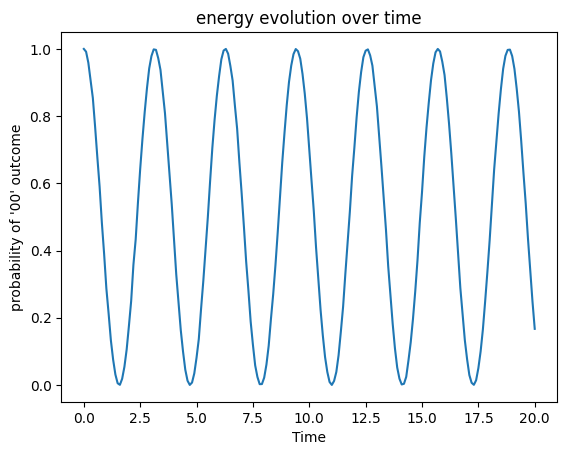

In [87]:
plt.plot(xpoints, ypoints_00)
# plt.plot(xpoints, ypoints_01)
# plt.plot(xpoints, ypoints_10)
# plt.plot(xpoints, ypoints_11)

plt.xlabel("Time")
plt.ylabel("probability of '00' outcome")
plt.title("energy evolution over time")
plt.show()

This line plots the normalized counts of the "00" outcome against the corresponding time steps and displays the graph. The plot shows a regular, sinusoidal oscillation, which is typical for coupled oscillators. This indicates that the energy is being transferred back and forth between the oscillators, indicating a periodic motion.

In [88]:
xpoints = []
ypoints_gates_1q = []
ypoints_gates_2q = []
ypoints_gates_total = []
ypoints_width = []
ypoints_depth = []
for key, counts in resources_used.items():
  xpoints.append(key)
  if "u" in counts['gate_counts'].keys():
    ypoints_gates_1q.append(counts['gate_counts']['u'])
  else:
    ypoints_gates_1q.append(0)
  if "cx" in counts['gate_counts'].keys():
    ypoints_gates_2q.append(counts['gate_counts']['cx'])
  else:
    ypoints_gates_2q.append(0)

  ypoints_gates_total.append(sum(counts['gate_counts'].values()))

  ypoints_width.append(counts['circuit_width'])

  ypoints_depth.append(counts['circuit_depth'])

This code block processes and organizes resource usage data across different time steps, including:
- Single-qubit (`u`) and two-qubit (`cx`) gate counts
- Total gate count
- Circuit width
- Circuit depth

These metrics are stored in separate lists for further analysis or visualization.

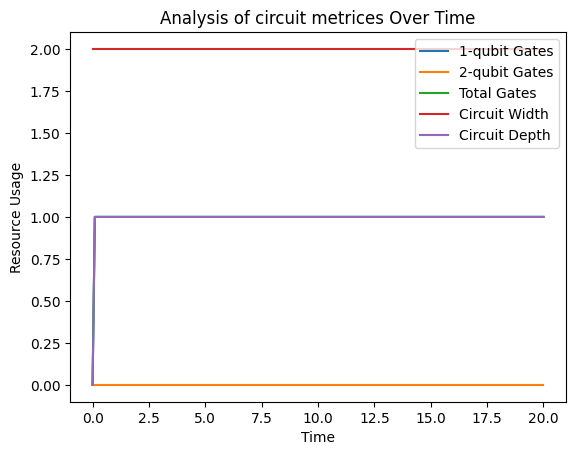

In [89]:
plt.plot(xpoints, ypoints_gates_1q, label='1-qubit Gates')
plt.plot(xpoints, ypoints_gates_2q, label='2-qubit Gates')
plt.plot(xpoints, ypoints_gates_total, label='Total Gates')
plt.plot(xpoints, ypoints_width, label='Circuit Width')
plt.plot(xpoints, ypoints_depth, label='Circuit Depth')
plt.title("Analysis of circuit metrices Over Time")
plt.xlabel("Time")
plt.ylabel("Resource Usage")
plt.legend(loc="upper right")

plt.show()

This line plots the number of single-qubit gates, two-qubit gates, total gate count, circuit width, and circuit depth against time steps, displaying all metrics on the same graph.



# **VQE for Optimal Energy:**

In [90]:
from typing import List
HAMILTONIAN = QConstant("HAMILTONIAN", List[PauliTerm], pauli_list_to_hamiltonian(pauli_list))

In [91]:
@qfunc
def main(q: Output[QArray[QBit]], angles: CArray[CReal, 6]) -> None:
    allocate(len(pauli_list[0][0]), q)
    repeat(q.len, lambda i: U(angles[0], angles[1], angles[2], 0, q[i]))
    repeat(q.len-1, lambda i: repeat(q.len-i-1, lambda j: CX(q[i], q[i+j+1])))
    repeat(q.len, lambda i: U(angles[3], angles[4], angles[5], 0, q[i]))



@cfunc
def cmain() -> None:
    res = vqe(
        HAMILTONIAN,
        False,
        [],
        optimizer=Optimizer.COBYLA,
        max_iteration=5000,
        tolerance=0.001,
        step_size=0,
        skip_compute_variance=False,
        alpha_cvar=1.0,
    )
    save({"result": res})

qmod = create_model(main, classical_execution_function=cmain)
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/541c31f4-b50b-43ce-ab7a-1d70e92a9e36?version=0.44.0


We are going to create a VQE algorithm to estimate the minimum energy (eigenvalue) of the calculated Hamiltonian. Execution of this program on classiq platform will show the graph of energy convergence as a function of iterations.
### **Code Inspiration**

For additional insights and examples you can refer to the following reference:

- [Variational Quantum Eigensolver (VQE) with Classiq](https://docs.classiq.io/latest/explore/community/basic_examples/vqe/vqe/)

In [92]:
execution = execute(qprog)
vqe_result = execution.result()[0].value

In [93]:
print(f"Optimal energy: {vqe_result.energy}")
print(f"Optimal parameters: {vqe_result.optimal_parameters}")
print(f"Eigenstate: {vqe_result.eigenstate}")

Optimal energy: -1.0
Optimal parameters: {'angles_param_0': 3.143790611898846, 'angles_param_1': 5.155076145086034, 'angles_param_2': 6.426481219140898, 'angles_param_3': 4.721770349086848, 'angles_param_4': 6.2837058521442435, 'angles_param_5': 2.543656684148041}
Eigenstate: {'01': (0.5043753872365304+0j), '11': (0.5053425508998821+0j), '00': (0.5009756106837937+0j), '10': (0.489139870078079+0j)}


We have added here an example of the circuit diagram and the plot for the fixed set of values.

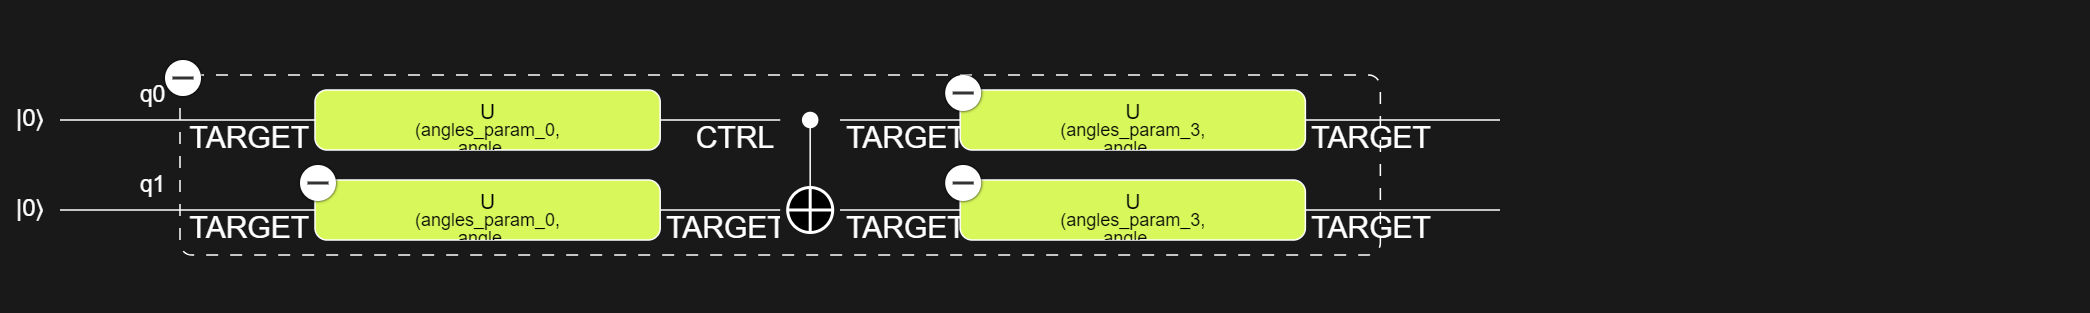
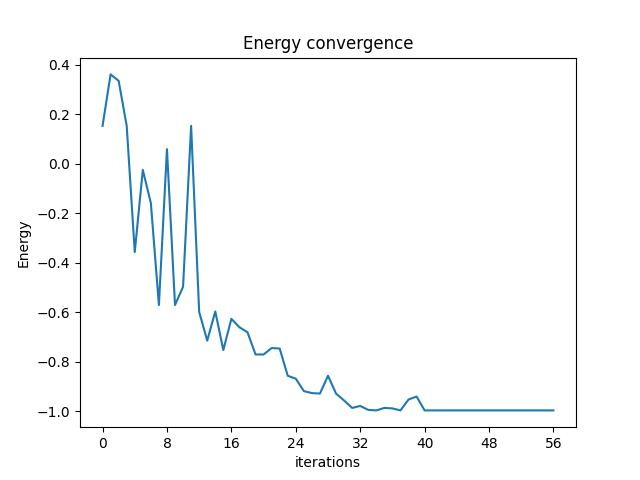

*Image credit: classiq platform*